In [1]:
%config InlineBackend.figure_format = 'svg'
import numpy as np
from numpy import genfromtxt
from sklearn.decomposition import PCA , KernelPCA
from sklearn.manifold import MDS,TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import h5py
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from autograd import grad
from tqdm import tqdm_notebook as tqdm
import math
import autograd.numpy as np
from sklearn.datasets import fetch_olivetti_faces

#Wine Data Set#  https://archive.ics.uci.edu/ml/Datasetss/wine
def getWineData():
    y= genfromtxt('Datasets/wineX.txt', delimiter=',')
    labels = genfromtxt('Datasets/wineY.txt', delimiter=',',dtype=np.int)
    labels=labels.astype(int)
    labels=labels-1
    return y,labels

# USPS Dataset# https://www.kaggle.com/bistaumanga/usps-dataset
def getUSPSData():
    filename='Datasets/usps.h5'
    with h5py.File(filename, 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_te = test.get('target')[:]
    y=X_tr
    labels=y_tr
    return y,labels

#Olivetti faces Datasets#    https://scikit-learn.org/0.19/Datasetss/olivetti_faces.html
def getOlivettiData():
    # y = genfromtxt('Datasets/olivettifacesX.txt', delimiter=',')
    # y= y/255
    # labels = genfromtxt('Datasets/olivettifacesY.txt', delimiter='\n',dtype=np.int)
    y=np.loadtxt("Datasets/olivetti_X.csv", delimiter = ",")
    labels=np.loadtxt("Datasets/olivetti_y.csv", delimiter = ",")
    labels=labels.astype(int)
    return y,labels

#Oil Flow Datasets#
def getOilFlowData():
    y=pd.read_csv('Datasets/OilflowX.txt', header=None, sep='\s+').values
    labels=(pd.read_csv('Datasets/OilflowY.txt', header=None, sep='\s+').values)
    labelstemp=[]
    for i in labels:
        labelstemp.append(np.where(i==1)[0][0])
    labels=np.asarray(labelstemp)
    return y,labels

#Vowel Datasets#    https://www.openml.org/d/58 
def getVowelDataset():
    y = genfromtxt('Datasets/vowelX.txt', delimiter=',')
    labels = genfromtxt('Datasets/vowelY.txt', delimiter=',',dtype=np.int)
    return y,labels

def getBreastCancerDataset():
    from sklearn.datasets import load_breast_cancer
    data = load_breast_cancer()
    y=data['data']
    labels=data['target']
    return y,labels

#http://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones
def getHARdataset():
    y=np.loadtxt('Datasets\X_test.txt')
    labels=np.loadtxt('Datasets\y_test.txt').astype(int)-1
    return y,labels

def plot2D(X,y,title):
    labels = np.unique(y)
    Ncolors = len(labels)
    xx = np.arange(Ncolors)
    ys = [i+xx+(i*xx)**2 for i in range(Ncolors)]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))
    c = 1.0
    for label in labels:
        classIdx = np.where(y==label)[0]
        Xclass = X[classIdx,:]
        plt.scatter(Xclass[:,0],Xclass[:,1],linewidths=1,s=1,color=colors[label],marker='o',alpha=0.75)
        c += 1.
    title+=',Classes:'+str(len(labels))
    plt.title(title, fontsize=10)
    filename="".join(t for t in title if t.isalnum())
    plt.savefig('Plots/'+filename+'.svg',format='svg', dpi=1200)
    plt.show()

# RBF kernel    
def rbf(X, sigma_f, length_scale, noise_coef=0.):
    num_points = X.shape[0]
    cov = np.dot(X, X.T)
    diag = np.diag(cov)
    # (x_n - x_m)' (x_n - x_m) = x_n'x_n + x_m'x_m - 2x_n'x_m
    cov_ = diag.reshape((num_points, 1)) + diag.reshape((1, num_points)) - 2 * cov
    return (sigma_f ** 2.) * np.exp(-1. / (2 * length_scale ** 2.) * cov_) + noise_coef * np.eye(num_points)

# Characteristic function for GP-LVM
def loglik(K, Y):
    
    D, N = Y.shape
    K_inv = np.linalg.inv(K)

    return -D*N/2*np.log(2*np.pi) - D/2*np.linalg.slogdet(K)[1] - 0.5*np.trace(np.dot(np.dot(K_inv, Y), Y.T))
 

def sievingGPLVMalgo(lowerDim, Y, alpha, beta, gamma):
    X, alpha, beta, gamma = GPLVMfit(Y, lowerDim, alpha, beta, gamma, num_iter=10, learn_rate=1e-5, verbose=False, log_every=1)
    return X


def GPLVMalgo(y, labels, title):
    alpha, beta, gamma = 1., 1e-4, 1.
    X, alpha, beta, gamma=GPLVMfit(y, 2, alpha, beta, gamma, num_iter=100, learn_rate=1e-5, verbose=True, log_every=1)
    # np.savetxt('GPLVMData/gplvm_lowX.txt',X)
    # save=[alpha,beta,gamma]
    # np.savetxt('GPLVMData/gplvm_Param.txt',save)
    title=title+', Algo:GPLVM'
    KNNScore(X,labels,title)
    plot2D(X,labels,title)


def GPLVMfit(Y, latent_dim, alpha, beta, gamma, learn_rate=1e-6, num_iter=100, verbose=True, log_every=50):    
    # Initial guess for X
    # pca = PCA(n_components=latent_dim)
    # X = pca.fit_transform(Y)
    from sklearn.manifold import Isomap
    X = Isomap(n_components=2)
    X_transformed = embedding.fit_transform(Y)
    K = rbf(X, alpha, gamma, beta)
    L = loglik(K, Y)
    loglik_lambda = lambda X_, alpha_, beta_, gamma_: loglik(rbf(X_, alpha_, gamma_, beta_), Y)
    theta = [X, alpha, beta, gamma]
    dloglik_dtheta = [grad(loglik_lambda, i) for i in range(len(theta))]
    for i in tqdm(range(num_iter)):
        
        grads = [loglik_partial(*theta) for loglik_partial in dloglik_dtheta]
        print('1')
        theta[0] = theta[0] + learn_rate * grads[0] #[theta[j] + learn_rate * gradient for j, gradient in enumerate(grads)]
        print('2')
        theta[1] = theta[1] + learn_rate * grads[1]
        print('3')
        theta[2] = theta[2] + 1e-15 * grads[2]
        print('4')
        theta[3] = theta[3] + 1e-7 * grads[3]
        # save=tuple(theta[1],theta[2],theta[3])
        save=[theta,loglik_lambda(*theta)]
        save=np.asarray(save)  

        np.save('GPLVMData/gplvm_iter'+str(i)+'.npy',save)
        print("Log-likelihood (iteration {}): {:.3f}".format(i + 1, loglik_lambda(*theta)))
    
    if verbose:
        print("Final log-likelihood: {:.3f}".format(loglik_lambda(*theta)))
    return tuple(theta)

def ISOMapandPlot(y,labels,title,plot):
        latent_dim=2
        from sklearn.manifold import Isomap
        embedding = Isomap(n_components=2)
        X_transformed = embedding.fit_transform(y)
        title=title+', Algo:ISOMAP'
        KNNScore(X_transformed,labels,title)
        if(plot):
             plot2D(X_transformed,labels,title)


def PCAandPlot(y,labels,title,plot):
        latent_dim=2
        pca = PCA(n_components=latent_dim)
        X_pca = pca.fit_transform(y)
        X_pca = X_pca
        title=title+', Algo:PCA'
        KNNScore(X_pca,labels,title)
        if(plot):
             plot2D(X_pca,labels,title)

def KernelPCAandPlot(y,labels,title,plot):
        latent_dim=2
        kpca = KernelPCA(n_components=latent_dim,kernel='poly')
        X_kpca = kpca.fit_transform(y)
        X_kpca = X_kpca
        title=title+', Algo:Kernel PCA'
        KNNScore(X_kpca,labels,title)
        if(plot):
            plot2D(X_kpca,labels,title)

def MDSandPlot(y,labels,title,plot):
        latent_dim=2
        embedding = MDS(n_components=2,metric=False)
        X_transformed = embedding.fit_transform(y)
        title=title+', Algo:MDS'
        KNNScore(X_transformed,labels,title)
        if(plot):
            plot2D(X_transformed,labels,title)

def TSNEandPlot(y,labels,title,plot):
        X_embedded = TSNE(n_components=2).fit_transform(y)
        title+=', Algo:TSNE'
        KNNScore(X_embedded,labels,title)
        if(plot):
            plot2D(X_embedded,labels,title)      

def KNNScore(x,y,title):
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
        knn = KNeighborsClassifier(n_neighbors=1)
        # Fit a nearest neighbor classifier on the embedded training set
        knn.fit(X_train, y_train)
        # Compute the nearest neighbor accuracy on the embedded test set
        acc_knn = knn.score(X_test, y_test) #Return the mean accuracy on the given test data and labels.
        print(title+',Accuracy Score:'+str(acc_knn))

dataset_name='Dataset:Oil Flow'
y,labels=getOilFlowData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# PCAandPlot(y,labels,dataset_name,plot=True)
GPLVMalgo(y,labels,dataset_name)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

# dataset_name='Dataset:Vowels'
# y,labels=getVowelDataset()
# labels=labels.astype(int)
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

# dataset_name='Dataset:Human Activity Recognition Using Smartphones'
# y,labels=getHARdataset()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# y_train,y_test, labeels_train, labels_test = train_test_split(y, labels, test_size=0.33, random_state=42)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)
# GPLVMalgo(y_test,labels_test,dataset_name)


# dataset_name='Dataset:Olivetti faces'
# y,labels=getOlivettiData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# GPLVMalgo(y,labels,dataset_name)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

# dataset_name='Dataset:Wine (UCI)'
# y,labels=getWineData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

# dataset_name='Dataset:USPS Digits'
# y,labels=getUSPSData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# y_train,y_test, labeels_train, labels_test = train_test_split(y, labels, test_size=0.33, random_state=42)
# GPLVMalgo(y_test,labels_test,dataset_name)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)


NameError: name 'embedding' is not defined

In [2]:
%config InlineBackend.figure_format = 'svg'
import numpy as np
from numpy import genfromtxt
from sklearn.decomposition import PCA , KernelPCA
from sklearn.manifold import MDS,TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import h5py
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from autograd import grad
from tqdm import tqdm_notebook as tqdm
import math
import autograd.numpy as np
from sklearn.datasets import fetch_olivetti_faces

#Wine Data Set#  https://archive.ics.uci.edu/ml/Datasetss/wine
def getWineData():
    y= genfromtxt('Datasets/wineX.txt', delimiter=',')
    labels = genfromtxt('Datasets/wineY.txt', delimiter=',',dtype=np.int)
    labels=labels.astype(int)
    labels=labels-1
    return y,labels

# USPS Dataset# https://www.kaggle.com/bistaumanga/usps-dataset
def getUSPSData():
    filename='Datasets/usps.h5'
    with h5py.File(filename, 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_te = test.get('target')[:]
    y=X_tr
    labels=y_tr
    return y,labels

#Olivetti faces Datasets#    https://scikit-learn.org/0.19/Datasetss/olivetti_faces.html
def getOlivettiData():
    # y = genfromtxt('Datasets/olivettifacesX.txt', delimiter=',')
    # y= y/255
    # labels = genfromtxt('Datasets/olivettifacesY.txt', delimiter='\n',dtype=np.int)
    y=np.loadtxt("Datasets/olivetti_X.csv", delimiter = ",")
    labels=np.loadtxt("Datasets/olivetti_y.csv", delimiter = ",")
    labels=labels.astype(int)
    return y,labels

#Oil Flow Datasets#
def getOilFlowData():
    y=pd.read_csv('Datasets/OilflowX.txt', header=None, sep='\s+').values
    labels=(pd.read_csv('Datasets/OilflowY.txt', header=None, sep='\s+').values)
    labelstemp=[]
    for i in labels:
        labelstemp.append(np.where(i==1)[0][0])
    labels=np.asarray(labelstemp)
    return y,labels

#Vowel Datasets#    https://www.openml.org/d/58 
def getVowelDataset():
    y = genfromtxt('Datasets/vowelX.txt', delimiter=',')
    labels = genfromtxt('Datasets/vowelY.txt', delimiter=',',dtype=np.int)
    return y,labels

def getBreastCancerDataset():
    from sklearn.datasets import load_breast_cancer
    data = load_breast_cancer()
    y=data['data']
    labels=data['target']
    return y,labels

#http://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones
def getHARdataset():
    y=np.loadtxt('Datasets\X_test.txt')
    labels=np.loadtxt('Datasets\y_test.txt').astype(int)-1
    return y,labels

def plot2D(X,y,title):
    labels = np.unique(y)
    Ncolors = len(labels)
    xx = np.arange(Ncolors)
    ys = [i+xx+(i*xx)**2 for i in range(Ncolors)]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))
    c = 1.0
    for label in labels:
        classIdx = np.where(y==label)[0]
        Xclass = X[classIdx,:]
        plt.scatter(Xclass[:,0],Xclass[:,1],linewidths=1,s=1,color=colors[label],marker='o',alpha=0.75)
        c += 1.
    title+=',Classes:'+str(len(labels))
    plt.title(title, fontsize=10)
    filename="".join(t for t in title if t.isalnum())
    plt.savefig('Plots/'+filename+'.svg',format='svg', dpi=1200)
    plt.show()

# RBF kernel    
def rbf(X, sigma_f, length_scale, noise_coef=0.):
    num_points = X.shape[0]
    cov = np.dot(X, X.T)
    diag = np.diag(cov)
    # (x_n - x_m)' (x_n - x_m) = x_n'x_n + x_m'x_m - 2x_n'x_m
    cov_ = diag.reshape((num_points, 1)) + diag.reshape((1, num_points)) - 2 * cov
    return (sigma_f ** 2.) * np.exp(-1. / (2 * length_scale ** 2.) * cov_) + noise_coef * np.eye(num_points)

# Characteristic function for GP-LVM
def loglik(K, Y):
    
    D, N = Y.shape
    K_inv = np.linalg.inv(K)

    return -D*N/2*np.log(2*np.pi) - D/2*np.linalg.slogdet(K)[1] - 0.5*np.trace(np.dot(np.dot(K_inv, Y), Y.T))
 

def sievingGPLVMalgo(lowerDim, Y, alpha, beta, gamma):
    X, alpha, beta, gamma = GPLVMfit(Y, lowerDim, alpha, beta, gamma, num_iter=10, learn_rate=1e-5, verbose=False, log_every=1)
    return X


def GPLVMalgo(y, labels, title):
    alpha, beta, gamma = 1., 1e-4, 1.
    X, alpha, beta, gamma=GPLVMfit(y, 2, alpha, beta, gamma, num_iter=100, learn_rate=1e-5, verbose=True, log_every=1)
    # np.savetxt('GPLVMData/gplvm_lowX.txt',X)
    # save=[alpha,beta,gamma]
    # np.savetxt('GPLVMData/gplvm_Param.txt',save)
    title=title+', Algo:GPLVM'
    KNNScore(X,labels,title)
    plot2D(X,labels,title)


def GPLVMfit(Y, latent_dim, alpha, beta, gamma, learn_rate=1e-6, num_iter=100, verbose=True, log_every=50):    
    # Initial guess for X
    # pca = PCA(n_components=latent_dim)
    # X = pca.fit_transform(Y)
    from sklearn.manifold import Isomap
    embedding = Isomap(n_components=2)
    X_transformed = embedding.fit_transform(Y)
    K = rbf(X, alpha, gamma, beta)
    L = loglik(K, Y)
    loglik_lambda = lambda X_, alpha_, beta_, gamma_: loglik(rbf(X_, alpha_, gamma_, beta_), Y)
    theta = [X, alpha, beta, gamma]
    dloglik_dtheta = [grad(loglik_lambda, i) for i in range(len(theta))]
    for i in tqdm(range(num_iter)):
        
        grads = [loglik_partial(*theta) for loglik_partial in dloglik_dtheta]
        print('1')
        theta[0] = theta[0] + learn_rate * grads[0] #[theta[j] + learn_rate * gradient for j, gradient in enumerate(grads)]
        print('2')
        theta[1] = theta[1] + learn_rate * grads[1]
        print('3')
        theta[2] = theta[2] + 1e-15 * grads[2]
        print('4')
        theta[3] = theta[3] + 1e-7 * grads[3]
        # save=tuple(theta[1],theta[2],theta[3])
        save=[theta,loglik_lambda(*theta)]
        save=np.asarray(save)  

        np.save('GPLVMData/gplvm_iter'+str(i)+'.npy',save)
        print("Log-likelihood (iteration {}): {:.3f}".format(i + 1, loglik_lambda(*theta)))
    
    if verbose:
        print("Final log-likelihood: {:.3f}".format(loglik_lambda(*theta)))
    return tuple(theta)

def ISOMapandPlot(y,labels,title,plot):
        latent_dim=2
        from sklearn.manifold import Isomap
        embedding = Isomap(n_components=2)
        X_transformed = embedding.fit_transform(y)
        title=title+', Algo:ISOMAP'
        KNNScore(X_transformed,labels,title)
        if(plot):
             plot2D(X_transformed,labels,title)


def PCAandPlot(y,labels,title,plot):
        latent_dim=2
        pca = PCA(n_components=latent_dim)
        X_pca = pca.fit_transform(y)
        X_pca = X_pca
        title=title+', Algo:PCA'
        KNNScore(X_pca,labels,title)
        if(plot):
             plot2D(X_pca,labels,title)

def KernelPCAandPlot(y,labels,title,plot):
        latent_dim=2
        kpca = KernelPCA(n_components=latent_dim,kernel='poly')
        X_kpca = kpca.fit_transform(y)
        X_kpca = X_kpca
        title=title+', Algo:Kernel PCA'
        KNNScore(X_kpca,labels,title)
        if(plot):
            plot2D(X_kpca,labels,title)

def MDSandPlot(y,labels,title,plot):
        latent_dim=2
        embedding = MDS(n_components=2,metric=False)
        X_transformed = embedding.fit_transform(y)
        title=title+', Algo:MDS'
        KNNScore(X_transformed,labels,title)
        if(plot):
            plot2D(X_transformed,labels,title)

def TSNEandPlot(y,labels,title,plot):
        X_embedded = TSNE(n_components=2).fit_transform(y)
        title+=', Algo:TSNE'
        KNNScore(X_embedded,labels,title)
        if(plot):
            plot2D(X_embedded,labels,title)      

def KNNScore(x,y,title):
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
        knn = KNeighborsClassifier(n_neighbors=1)
        # Fit a nearest neighbor classifier on the embedded training set
        knn.fit(X_train, y_train)
        # Compute the nearest neighbor accuracy on the embedded test set
        acc_knn = knn.score(X_test, y_test) #Return the mean accuracy on the given test data and labels.
        print(title+',Accuracy Score:'+str(acc_knn))

dataset_name='Dataset:Oil Flow'
y,labels=getOilFlowData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# PCAandPlot(y,labels,dataset_name,plot=True)
GPLVMalgo(y,labels,dataset_name)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

# dataset_name='Dataset:Vowels'
# y,labels=getVowelDataset()
# labels=labels.astype(int)
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

# dataset_name='Dataset:Human Activity Recognition Using Smartphones'
# y,labels=getHARdataset()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# y_train,y_test, labeels_train, labels_test = train_test_split(y, labels, test_size=0.33, random_state=42)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)
# GPLVMalgo(y_test,labels_test,dataset_name)


# dataset_name='Dataset:Olivetti faces'
# y,labels=getOlivettiData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# GPLVMalgo(y,labels,dataset_name)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

# dataset_name='Dataset:Wine (UCI)'
# y,labels=getWineData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

# dataset_name='Dataset:USPS Digits'
# y,labels=getUSPSData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# y_train,y_test, labeels_train, labels_test = train_test_split(y, labels, test_size=0.33, random_state=42)
# GPLVMalgo(y_test,labels_test,dataset_name)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)


NameError: name 'X' is not defined

c:\Users\aniru\OneDrive\GIT\GPLVMandPCA\main.py:144: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  print('1')


1
2
3
4
Log-likelihood (iteration 1): 2883337.743
1
2
3
4
Log-likelihood (iteration 2): 2604656.829
1
2
3
4
Log-likelihood (iteration 3): 3229350.303
1
2
3
4
Log-likelihood (iteration 4): 3436460.118
1
2
3
4
Log-likelihood (iteration 5): 3586379.460
1
2
3
4
Log-likelihood (iteration 6): 3691963.165
1
2
3
4
Log-likelihood (iteration 7): 3542676.336
1
2
3
4
Log-likelihood (iteration 8): 3669621.012
1
2
3
4
Log-likelihood (iteration 9): 2890480.953
1
2
3
4
Log-likelihood (iteration 10): 3097564.187
1
2
3
4
Log-likelihood (iteration 11): 3239399.704
1
2
3
4
Log-likelihood (iteration 12): 3330929.534
1
2
3
4
Log-likelihood (iteration 13): 3383652.599
1
2
3
4
Log-likelihood (iteration 14): 3425104.094
1
2
3
4
Log-likelihood (iteration 15): 3452521.471
1
2
3
4
Log-likelihood (iteration 16): 3481352.347
1
2
3
4
Log-likelihood (iteration 17): 3506531.955
1
2
3
4
Log-likelihood (iteration 18): 3524139.770
1
2
3
4
Log-likelihood (iteration 19): 3544963.934
1
2
3
4
Log-likelihood (iteration 20): 3

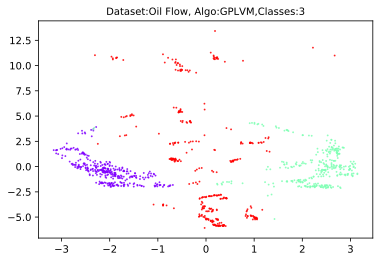

In [3]:
%config InlineBackend.figure_format = 'svg'
import numpy as np
from numpy import genfromtxt
from sklearn.decomposition import PCA , KernelPCA
from sklearn.manifold import MDS,TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import h5py
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from autograd import grad
from tqdm import tqdm_notebook as tqdm
import math
import autograd.numpy as np
from sklearn.datasets import fetch_olivetti_faces

#Wine Data Set#  https://archive.ics.uci.edu/ml/Datasetss/wine
def getWineData():
    y= genfromtxt('Datasets/wineX.txt', delimiter=',')
    labels = genfromtxt('Datasets/wineY.txt', delimiter=',',dtype=np.int)
    labels=labels.astype(int)
    labels=labels-1
    return y,labels

# USPS Dataset# https://www.kaggle.com/bistaumanga/usps-dataset
def getUSPSData():
    filename='Datasets/usps.h5'
    with h5py.File(filename, 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_te = test.get('target')[:]
    y=X_tr
    labels=y_tr
    return y,labels

#Olivetti faces Datasets#    https://scikit-learn.org/0.19/Datasetss/olivetti_faces.html
def getOlivettiData():
    # y = genfromtxt('Datasets/olivettifacesX.txt', delimiter=',')
    # y= y/255
    # labels = genfromtxt('Datasets/olivettifacesY.txt', delimiter='\n',dtype=np.int)
    y=np.loadtxt("Datasets/olivetti_X.csv", delimiter = ",")
    labels=np.loadtxt("Datasets/olivetti_y.csv", delimiter = ",")
    labels=labels.astype(int)
    return y,labels

#Oil Flow Datasets#
def getOilFlowData():
    y=pd.read_csv('Datasets/OilflowX.txt', header=None, sep='\s+').values
    labels=(pd.read_csv('Datasets/OilflowY.txt', header=None, sep='\s+').values)
    labelstemp=[]
    for i in labels:
        labelstemp.append(np.where(i==1)[0][0])
    labels=np.asarray(labelstemp)
    return y,labels

#Vowel Datasets#    https://www.openml.org/d/58 
def getVowelDataset():
    y = genfromtxt('Datasets/vowelX.txt', delimiter=',')
    labels = genfromtxt('Datasets/vowelY.txt', delimiter=',',dtype=np.int)
    return y,labels

def getBreastCancerDataset():
    from sklearn.datasets import load_breast_cancer
    data = load_breast_cancer()
    y=data['data']
    labels=data['target']
    return y,labels

#http://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones
def getHARdataset():
    y=np.loadtxt('Datasets\X_test.txt')
    labels=np.loadtxt('Datasets\y_test.txt').astype(int)-1
    return y,labels

def plot2D(X,y,title):
    labels = np.unique(y)
    Ncolors = len(labels)
    xx = np.arange(Ncolors)
    ys = [i+xx+(i*xx)**2 for i in range(Ncolors)]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))
    c = 1.0
    for label in labels:
        classIdx = np.where(y==label)[0]
        Xclass = X[classIdx,:]
        plt.scatter(Xclass[:,0],Xclass[:,1],linewidths=1,s=1,color=colors[label],marker='o',alpha=0.75)
        c += 1.
    title+=',Classes:'+str(len(labels))
    plt.title(title, fontsize=10)
    filename="".join(t for t in title if t.isalnum())
    plt.savefig('Plots/'+filename+'.svg',format='svg', dpi=1200)
    plt.show()

# RBF kernel    
def rbf(X, sigma_f, length_scale, noise_coef=0.):
    num_points = X.shape[0]
    cov = np.dot(X, X.T)
    diag = np.diag(cov)
    # (x_n - x_m)' (x_n - x_m) = x_n'x_n + x_m'x_m - 2x_n'x_m
    cov_ = diag.reshape((num_points, 1)) + diag.reshape((1, num_points)) - 2 * cov
    return (sigma_f ** 2.) * np.exp(-1. / (2 * length_scale ** 2.) * cov_) + noise_coef * np.eye(num_points)

# Characteristic function for GP-LVM
def loglik(K, Y):
    
    D, N = Y.shape
    K_inv = np.linalg.inv(K)

    return -D*N/2*np.log(2*np.pi) - D/2*np.linalg.slogdet(K)[1] - 0.5*np.trace(np.dot(np.dot(K_inv, Y), Y.T))
 

def sievingGPLVMalgo(lowerDim, Y, alpha, beta, gamma):
    X, alpha, beta, gamma = GPLVMfit(Y, lowerDim, alpha, beta, gamma, num_iter=10, learn_rate=1e-5, verbose=False, log_every=1)
    return X


def GPLVMalgo(y, labels, title):
    alpha, beta, gamma = 1., 1e-4, 1.
    X, alpha, beta, gamma=GPLVMfit(y, 2, alpha, beta, gamma, num_iter=100, learn_rate=1e-5, verbose=True, log_every=1)
    # np.savetxt('GPLVMData/gplvm_lowX.txt',X)
    # save=[alpha,beta,gamma]
    # np.savetxt('GPLVMData/gplvm_Param.txt',save)
    title=title+', Algo:GPLVM'
    KNNScore(X,labels,title)
    plot2D(X,labels,title)


def GPLVMfit(Y, latent_dim, alpha, beta, gamma, learn_rate=1e-6, num_iter=100, verbose=True, log_every=50):    
    # Initial guess for X
    # pca = PCA(n_components=latent_dim)
    # X = pca.fit_transform(Y)
    from sklearn.manifold import Isomap
    embedding = Isomap(n_components=2)
    X = embedding.fit_transform(Y)
    K = rbf(X, alpha, gamma, beta)
    L = loglik(K, Y)
    loglik_lambda = lambda X_, alpha_, beta_, gamma_: loglik(rbf(X_, alpha_, gamma_, beta_), Y)
    theta = [X, alpha, beta, gamma]
    dloglik_dtheta = [grad(loglik_lambda, i) for i in range(len(theta))]
    for i in tqdm(range(num_iter)):
        
        grads = [loglik_partial(*theta) for loglik_partial in dloglik_dtheta]
        print('1')
        theta[0] = theta[0] + learn_rate * grads[0] #[theta[j] + learn_rate * gradient for j, gradient in enumerate(grads)]
        print('2')
        theta[1] = theta[1] + learn_rate * grads[1]
        print('3')
        theta[2] = theta[2] + 1e-15 * grads[2]
        print('4')
        theta[3] = theta[3] + 1e-7 * grads[3]
        # save=tuple(theta[1],theta[2],theta[3])
        save=[theta,loglik_lambda(*theta)]
        save=np.asarray(save)  

        np.save('GPLVMData/gplvm_iter'+str(i)+'.npy',save)
        print("Log-likelihood (iteration {}): {:.3f}".format(i + 1, loglik_lambda(*theta)))
    
    if verbose:
        print("Final log-likelihood: {:.3f}".format(loglik_lambda(*theta)))
    return tuple(theta)

def ISOMapandPlot(y,labels,title,plot):
        latent_dim=2
        from sklearn.manifold import Isomap
        embedding = Isomap(n_components=2)
        X_transformed = embedding.fit_transform(y)
        title=title+', Algo:ISOMAP'
        KNNScore(X_transformed,labels,title)
        if(plot):
             plot2D(X_transformed,labels,title)


def PCAandPlot(y,labels,title,plot):
        latent_dim=2
        pca = PCA(n_components=latent_dim)
        X_pca = pca.fit_transform(y)
        X_pca = X_pca
        title=title+', Algo:PCA'
        KNNScore(X_pca,labels,title)
        if(plot):
             plot2D(X_pca,labels,title)

def KernelPCAandPlot(y,labels,title,plot):
        latent_dim=2
        kpca = KernelPCA(n_components=latent_dim,kernel='poly')
        X_kpca = kpca.fit_transform(y)
        X_kpca = X_kpca
        title=title+', Algo:Kernel PCA'
        KNNScore(X_kpca,labels,title)
        if(plot):
            plot2D(X_kpca,labels,title)

def MDSandPlot(y,labels,title,plot):
        latent_dim=2
        embedding = MDS(n_components=2,metric=False)
        X_transformed = embedding.fit_transform(y)
        title=title+', Algo:MDS'
        KNNScore(X_transformed,labels,title)
        if(plot):
            plot2D(X_transformed,labels,title)

def TSNEandPlot(y,labels,title,plot):
        X_embedded = TSNE(n_components=2).fit_transform(y)
        title+=', Algo:TSNE'
        KNNScore(X_embedded,labels,title)
        if(plot):
            plot2D(X_embedded,labels,title)      

def KNNScore(x,y,title):
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
        knn = KNeighborsClassifier(n_neighbors=1)
        # Fit a nearest neighbor classifier on the embedded training set
        knn.fit(X_train, y_train)
        # Compute the nearest neighbor accuracy on the embedded test set
        acc_knn = knn.score(X_test, y_test) #Return the mean accuracy on the given test data and labels.
        print(title+',Accuracy Score:'+str(acc_knn))

dataset_name='Dataset:Oil Flow'
y,labels=getOilFlowData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# PCAandPlot(y,labels,dataset_name,plot=True)
GPLVMalgo(y,labels,dataset_name)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

# dataset_name='Dataset:Vowels'
# y,labels=getVowelDataset()
# labels=labels.astype(int)
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

# dataset_name='Dataset:Human Activity Recognition Using Smartphones'
# y,labels=getHARdataset()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# y_train,y_test, labeels_train, labels_test = train_test_split(y, labels, test_size=0.33, random_state=42)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)
# GPLVMalgo(y_test,labels_test,dataset_name)


# dataset_name='Dataset:Olivetti faces'
# y,labels=getOlivettiData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# GPLVMalgo(y,labels,dataset_name)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

# dataset_name='Dataset:Wine (UCI)'
# y,labels=getWineData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

# dataset_name='Dataset:USPS Digits'
# y,labels=getUSPSData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# y_train,y_test, labeels_train, labels_test = train_test_split(y, labels, test_size=0.33, random_state=42)
# GPLVMalgo(y_test,labels_test,dataset_name)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)


c:\Users\aniru\OneDrive\GIT\GPLVMandPCA\main.py:144: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  print('1')


1
2
3
4
Log-likelihood (iteration 1): 3195210.286
1
2
3
4
Log-likelihood (iteration 2): 3546952.735
1
2
3
4
Log-likelihood (iteration 3): 3758123.746
1
2
3
4
Log-likelihood (iteration 4): 3778192.970
1
2
3
4
Log-likelihood (iteration 5): 3829318.376
1
2
3
4
Log-likelihood (iteration 6): 3861928.450
1
2
3
4
Log-likelihood (iteration 7): 3892332.311
1
2
3
4
Log-likelihood (iteration 8): 3920114.682
1
2
3
4
Log-likelihood (iteration 9): 3940531.283
1
2
3
4
Log-likelihood (iteration 10): 3973526.775
1
2
3
4
Log-likelihood (iteration 11): 3982745.465
1
2
3
4
Log-likelihood (iteration 12): 3986798.489
1
2
3
4
Log-likelihood (iteration 13): 3985630.771
1
2
3
4
Log-likelihood (iteration 14): 3940134.600
1
2
3
4
Log-likelihood (iteration 15): 3975238.932
1
2
3
4
Log-likelihood (iteration 16): 4001759.120
1
2
3
4
Log-likelihood (iteration 17): 4003171.943
1
2
3
4
Log-likelihood (iteration 18): 3943854.391
1
2
3
4
Log-likelihood (iteration 19): 3977352.652
1
2
3
4
Log-likelihood (iteration 20): 3

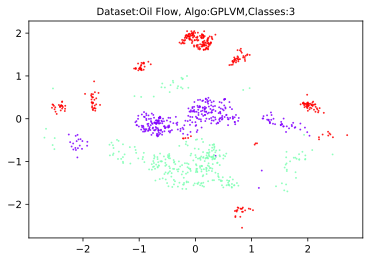

In [4]:
%config InlineBackend.figure_format = 'svg'
import numpy as np
from numpy import genfromtxt
from sklearn.decomposition import PCA , KernelPCA
from sklearn.manifold import MDS,TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import h5py
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from autograd import grad
from tqdm import tqdm_notebook as tqdm
import math
import autograd.numpy as np
from sklearn.datasets import fetch_olivetti_faces

#Wine Data Set#  https://archive.ics.uci.edu/ml/Datasetss/wine
def getWineData():
    y= genfromtxt('Datasets/wineX.txt', delimiter=',')
    labels = genfromtxt('Datasets/wineY.txt', delimiter=',',dtype=np.int)
    labels=labels.astype(int)
    labels=labels-1
    return y,labels

# USPS Dataset# https://www.kaggle.com/bistaumanga/usps-dataset
def getUSPSData():
    filename='Datasets/usps.h5'
    with h5py.File(filename, 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_te = test.get('target')[:]
    y=X_tr
    labels=y_tr
    return y,labels

#Olivetti faces Datasets#    https://scikit-learn.org/0.19/Datasetss/olivetti_faces.html
def getOlivettiData():
    # y = genfromtxt('Datasets/olivettifacesX.txt', delimiter=',')
    # y= y/255
    # labels = genfromtxt('Datasets/olivettifacesY.txt', delimiter='\n',dtype=np.int)
    y=np.loadtxt("Datasets/olivetti_X.csv", delimiter = ",")
    labels=np.loadtxt("Datasets/olivetti_y.csv", delimiter = ",")
    labels=labels.astype(int)
    return y,labels

#Oil Flow Datasets#
def getOilFlowData():
    y=pd.read_csv('Datasets/OilflowX.txt', header=None, sep='\s+').values
    labels=(pd.read_csv('Datasets/OilflowY.txt', header=None, sep='\s+').values)
    labelstemp=[]
    for i in labels:
        labelstemp.append(np.where(i==1)[0][0])
    labels=np.asarray(labelstemp)
    return y,labels

#Vowel Datasets#    https://www.openml.org/d/58 
def getVowelDataset():
    y = genfromtxt('Datasets/vowelX.txt', delimiter=',')
    labels = genfromtxt('Datasets/vowelY.txt', delimiter=',',dtype=np.int)
    return y,labels

def getBreastCancerDataset():
    from sklearn.datasets import load_breast_cancer
    data = load_breast_cancer()
    y=data['data']
    labels=data['target']
    return y,labels

#http://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones
def getHARdataset():
    y=np.loadtxt('Datasets\X_test.txt')
    labels=np.loadtxt('Datasets\y_test.txt').astype(int)-1
    return y,labels

def plot2D(X,y,title):
    labels = np.unique(y)
    Ncolors = len(labels)
    xx = np.arange(Ncolors)
    ys = [i+xx+(i*xx)**2 for i in range(Ncolors)]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))
    c = 1.0
    for label in labels:
        classIdx = np.where(y==label)[0]
        Xclass = X[classIdx,:]
        plt.scatter(Xclass[:,0],Xclass[:,1],linewidths=1,s=1,color=colors[label],marker='o',alpha=0.75)
        c += 1.
    title+=',Classes:'+str(len(labels))
    plt.title(title, fontsize=10)
    filename="".join(t for t in title if t.isalnum())
    plt.savefig('Plots/'+filename+'.svg',format='svg', dpi=1200)
    plt.show()

# RBF kernel    
def rbf(X, sigma_f, length_scale, noise_coef=0.):
    num_points = X.shape[0]
    cov = np.dot(X, X.T)
    diag = np.diag(cov)
    # (x_n - x_m)' (x_n - x_m) = x_n'x_n + x_m'x_m - 2x_n'x_m
    cov_ = diag.reshape((num_points, 1)) + diag.reshape((1, num_points)) - 2 * cov
    return (sigma_f ** 2.) * np.exp(-1. / (2 * length_scale ** 2.) * cov_) + noise_coef * np.eye(num_points)

# Characteristic function for GP-LVM
def loglik(K, Y):
    
    D, N = Y.shape
    K_inv = np.linalg.inv(K)

    return -D*N/2*np.log(2*np.pi) - D/2*np.linalg.slogdet(K)[1] - 0.5*np.trace(np.dot(np.dot(K_inv, Y), Y.T))
 

def sievingGPLVMalgo(lowerDim, Y, alpha, beta, gamma):
    X, alpha, beta, gamma = GPLVMfit(Y, lowerDim, alpha, beta, gamma, num_iter=10, learn_rate=1e-5, verbose=False, log_every=1)
    return X


def GPLVMalgo(y, labels, title):
    alpha, beta, gamma = 1., 1e-4, 1.
    X, alpha, beta, gamma=GPLVMfit(y, 2, alpha, beta, gamma, num_iter=100, learn_rate=1e-5, verbose=True, log_every=1)
    # np.savetxt('GPLVMData/gplvm_lowX.txt',X)
    # save=[alpha,beta,gamma]
    # np.savetxt('GPLVMData/gplvm_Param.txt',save)
    title=title+', Algo:GPLVM'
    KNNScore(X,labels,title)
    plot2D(X,labels,title)


def GPLVMfit(Y, latent_dim, alpha, beta, gamma, learn_rate=1e-6, num_iter=100, verbose=True, log_every=50):    
    # Initial guess for X
    pca = PCA(n_components=latent_dim)
    X = pca.fit_transform(Y)
    # from sklearn.manifold import Isomap
    # embedding = Isomap(n_components=2)
    # X = embedding.fit_transform(Y)
    K = rbf(X, alpha, gamma, beta)
    L = loglik(K, Y)
    loglik_lambda = lambda X_, alpha_, beta_, gamma_: loglik(rbf(X_, alpha_, gamma_, beta_), Y)
    theta = [X, alpha, beta, gamma]
    dloglik_dtheta = [grad(loglik_lambda, i) for i in range(len(theta))]
    for i in tqdm(range(num_iter)):
        
        grads = [loglik_partial(*theta) for loglik_partial in dloglik_dtheta]
        print('1')
        theta[0] = theta[0] + learn_rate * grads[0] #[theta[j] + learn_rate * gradient for j, gradient in enumerate(grads)]
        print('2')
        theta[1] = theta[1] + learn_rate * grads[1]
        print('3')
        theta[2] = theta[2] + 1e-15 * grads[2]
        print('4')
        theta[3] = theta[3] + 1e-7 * grads[3]
        # save=tuple(theta[1],theta[2],theta[3])
        save=[theta,loglik_lambda(*theta)]
        save=np.asarray(save)  

        np.save('GPLVMData/gplvm_iter'+str(i)+'.npy',save)
        print("Log-likelihood (iteration {}): {:.3f}".format(i + 1, loglik_lambda(*theta)))
    
    if verbose:
        print("Final log-likelihood: {:.3f}".format(loglik_lambda(*theta)))
    return tuple(theta)

def ISOMapandPlot(y,labels,title,plot):
        latent_dim=2
        from sklearn.manifold import Isomap
        embedding = Isomap(n_components=2)
        X_transformed = embedding.fit_transform(y)
        title=title+', Algo:ISOMAP'
        KNNScore(X_transformed,labels,title)
        if(plot):
             plot2D(X_transformed,labels,title)


def PCAandPlot(y,labels,title,plot):
        latent_dim=2
        pca = PCA(n_components=latent_dim)
        X_pca = pca.fit_transform(y)
        X_pca = X_pca
        title=title+', Algo:PCA'
        KNNScore(X_pca,labels,title)
        if(plot):
             plot2D(X_pca,labels,title)

def KernelPCAandPlot(y,labels,title,plot):
        latent_dim=2
        kpca = KernelPCA(n_components=latent_dim,kernel='poly')
        X_kpca = kpca.fit_transform(y)
        X_kpca = X_kpca
        title=title+', Algo:Kernel PCA'
        KNNScore(X_kpca,labels,title)
        if(plot):
            plot2D(X_kpca,labels,title)

def MDSandPlot(y,labels,title,plot):
        latent_dim=2
        embedding = MDS(n_components=2,metric=False)
        X_transformed = embedding.fit_transform(y)
        title=title+', Algo:MDS'
        KNNScore(X_transformed,labels,title)
        if(plot):
            plot2D(X_transformed,labels,title)

def TSNEandPlot(y,labels,title,plot):
        X_embedded = TSNE(n_components=2).fit_transform(y)
        title+=', Algo:TSNE'
        KNNScore(X_embedded,labels,title)
        if(plot):
            plot2D(X_embedded,labels,title)      

def KNNScore(x,y,title):
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
        knn = KNeighborsClassifier(n_neighbors=1)
        # Fit a nearest neighbor classifier on the embedded training set
        knn.fit(X_train, y_train)
        # Compute the nearest neighbor accuracy on the embedded test set
        acc_knn = knn.score(X_test, y_test) #Return the mean accuracy on the given test data and labels.
        print(title+',Accuracy Score:'+str(acc_knn))

dataset_name='Dataset:Oil Flow'
y,labels=getOilFlowData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# PCAandPlot(y,labels,dataset_name,plot=True)
GPLVMalgo(y,labels,dataset_name)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

# dataset_name='Dataset:Vowels'
# y,labels=getVowelDataset()
# labels=labels.astype(int)
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

# dataset_name='Dataset:Human Activity Recognition Using Smartphones'
# y,labels=getHARdataset()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# y_train,y_test, labeels_train, labels_test = train_test_split(y, labels, test_size=0.33, random_state=42)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)
# GPLVMalgo(y_test,labels_test,dataset_name)


# dataset_name='Dataset:Olivetti faces'
# y,labels=getOlivettiData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# GPLVMalgo(y,labels,dataset_name)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

# dataset_name='Dataset:Wine (UCI)'
# y,labels=getWineData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

# dataset_name='Dataset:USPS Digits'
# y,labels=getUSPSData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# y_train,y_test, labeels_train, labels_test = train_test_split(y, labels, test_size=0.33, random_state=42)
# GPLVMalgo(y_test,labels_test,dataset_name)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)


In [5]:
%config InlineBackend.figure_format = 'svg'
import numpy as np
from numpy import genfromtxt
from sklearn.decomposition import PCA , KernelPCA
from sklearn.manifold import MDS,TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import h5py
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from autograd import grad
from tqdm import tqdm_notebook as tqdm
import math
import autograd.numpy as np
from sklearn.datasets import fetch_olivetti_faces

#Wine Data Set#  https://archive.ics.uci.edu/ml/Datasetss/wine
def getWineData():
    y= genfromtxt('Datasets/wineX.txt', delimiter=',')
    labels = genfromtxt('Datasets/wineY.txt', delimiter=',',dtype=np.int)
    labels=labels.astype(int)
    labels=labels-1
    return y,labels

# USPS Dataset# https://www.kaggle.com/bistaumanga/usps-dataset
def getUSPSData():
    filename='Datasets/usps.h5'
    with h5py.File(filename, 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_te = test.get('target')[:]
    y=X_tr
    labels=y_tr
    return y,labels

#Olivetti faces Datasets#    https://scikit-learn.org/0.19/Datasetss/olivetti_faces.html
def getOlivettiData():
    # y = genfromtxt('Datasets/olivettifacesX.txt', delimiter=',')
    # y= y/255
    # labels = genfromtxt('Datasets/olivettifacesY.txt', delimiter='\n',dtype=np.int)
    y=np.loadtxt("Datasets/olivetti_X.csv", delimiter = ",")
    labels=np.loadtxt("Datasets/olivetti_y.csv", delimiter = ",")
    labels=labels.astype(int)
    return y,labels

#Oil Flow Datasets#
def getOilFlowData():
    y=pd.read_csv('Datasets/OilflowX.txt', header=None, sep='\s+').values
    labels=(pd.read_csv('Datasets/OilflowY.txt', header=None, sep='\s+').values)
    labelstemp=[]
    for i in labels:
        labelstemp.append(np.where(i==1)[0][0])
    labels=np.asarray(labelstemp)
    return y,labels

#Vowel Datasets#    https://www.openml.org/d/58 
def getVowelDataset():
    y = genfromtxt('Datasets/vowelX.txt', delimiter=',')
    labels = genfromtxt('Datasets/vowelY.txt', delimiter=',',dtype=np.int)
    return y,labels

def getBreastCancerDataset():
    from sklearn.datasets import load_breast_cancer
    data = load_breast_cancer()
    y=data['data']
    labels=data['target']
    return y,labels

#http://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones
def getHARdataset():
    y=np.loadtxt('Datasets\X_test.txt')
    labels=np.loadtxt('Datasets\y_test.txt').astype(int)-1
    return y,labels

def plot2D(X,y,title):
    labels = np.unique(y)
    Ncolors = len(labels)
    xx = np.arange(Ncolors)
    ys = [i+xx+(i*xx)**2 for i in range(Ncolors)]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))
    c = 1.0
    for label in labels:
        classIdx = np.where(y==label)[0]
        Xclass = X[classIdx,:]
        plt.scatter(Xclass[:,0],Xclass[:,1],linewidths=1,s=1,color=colors[label],marker='o',alpha=0.75)
        c += 1.
    title+=',Classes:'+str(len(labels))
    plt.title(title, fontsize=10)
    filename="".join(t for t in title if t.isalnum())
    plt.savefig('Plots/'+filename+'.svg',format='svg', dpi=1200)
    plt.show()

# RBF kernel    
def rbf(X, sigma_f, length_scale, noise_coef=0.):
    num_points = X.shape[0]
    cov = np.dot(X, X.T)
    diag = np.diag(cov)
    # (x_n - x_m)' (x_n - x_m) = x_n'x_n + x_m'x_m - 2x_n'x_m
    cov_ = diag.reshape((num_points, 1)) + diag.reshape((1, num_points)) - 2 * cov
    return (sigma_f ** 2.) * np.exp(-1. / (2 * length_scale ** 2.) * cov_) + noise_coef * np.eye(num_points)

# Characteristic function for GP-LVM
def loglik(K, Y):
    
    D, N = Y.shape
    K_inv = np.linalg.inv(K)

    return -D*N/2*np.log(2*np.pi) - D/2*np.linalg.slogdet(K)[1] - 0.5*np.trace(np.dot(np.dot(K_inv, Y), Y.T))
 

def sievingGPLVMalgo(lowerDim, Y, alpha, beta, gamma):
    X, alpha, beta, gamma = GPLVMfit(Y, lowerDim, alpha, beta, gamma, num_iter=10, learn_rate=1e-5, verbose=False, log_every=1)
    return X


def GPLVMalgo(y, labels, title):
    alpha, beta, gamma = 1., 1e-4, 1.
    X, alpha, beta, gamma=GPLVMfit(y, 2, alpha, beta, gamma, num_iter=100, learn_rate=1e-5, verbose=True, log_every=1)
    # np.savetxt('GPLVMData/gplvm_lowX.txt',X)
    # save=[alpha,beta,gamma]
    # np.savetxt('GPLVMData/gplvm_Param.txt',save)
    title=title+', Algo:GPLVM'
    KNNScore(X,labels,title)
    plot2D(X,labels,title)


def GPLVMfit(Y, latent_dim, alpha, beta, gamma, learn_rate=1e-6, num_iter=100, verbose=True, log_every=50):    
    # Initial guess for X
    # pca = PCA(n_components=latent_dim)
    # X = pca.fit_transform(Y)
    from sklearn.manifold import Isomap
    embedding = Isomap(n_components=2)
    X = embedding.fit_transform(Y)
    K = rbf(X, alpha, gamma, beta)
    L = loglik(K, Y)
    loglik_lambda = lambda X_, alpha_, beta_, gamma_: loglik(rbf(X_, alpha_, gamma_, beta_), Y)
    theta = [X, alpha, beta, gamma]
    dloglik_dtheta = [grad(loglik_lambda, i) for i in range(len(theta))]
    for i in tqdm(range(num_iter)):
        
        grads = [loglik_partial(*theta) for loglik_partial in dloglik_dtheta]
        print('1')
        theta[0] = theta[0] + learn_rate * grads[0] #[theta[j] + learn_rate * gradient for j, gradient in enumerate(grads)]
        print('2')
        theta[1] = theta[1] + learn_rate * grads[1]
        print('3')
        theta[2] = theta[2] + 1e-15 * grads[2]
        print('4')
        theta[3] = theta[3] + 1e-7 * grads[3]
        # save=tuple(theta[1],theta[2],theta[3])
        save=[theta,loglik_lambda(*theta)]
        save=np.asarray(save)  

        np.save('GPLVMData/gplvm_iter'+str(i)+'.npy',save)
        print("Log-likelihood (iteration {}): {:.3f}".format(i + 1, loglik_lambda(*theta)))
    
    if verbose:
        print("Final log-likelihood: {:.3f}".format(loglik_lambda(*theta)))
    return tuple(theta)

def ISOMapandPlot(y,labels,title,plot):
        latent_dim=2
        from sklearn.manifold import Isomap
        embedding = Isomap(n_components=2)
        X_transformed = embedding.fit_transform(y)
        title=title+', Algo:ISOMAP'
        KNNScore(X_transformed,labels,title)
        if(plot):
             plot2D(X_transformed,labels,title)


def PCAandPlot(y,labels,title,plot):
        latent_dim=2
        pca = PCA(n_components=latent_dim)
        X_pca = pca.fit_transform(y)
        X_pca = X_pca
        title=title+', Algo:PCA'
        KNNScore(X_pca,labels,title)
        if(plot):
             plot2D(X_pca,labels,title)

def KernelPCAandPlot(y,labels,title,plot):
        latent_dim=2
        kpca = KernelPCA(n_components=latent_dim,kernel='poly')
        X_kpca = kpca.fit_transform(y)
        X_kpca = X_kpca
        title=title+', Algo:Kernel PCA'
        KNNScore(X_kpca,labels,title)
        if(plot):
            plot2D(X_kpca,labels,title)

def MDSandPlot(y,labels,title,plot):
        latent_dim=2
        embedding = MDS(n_components=2,metric=False)
        X_transformed = embedding.fit_transform(y)
        title=title+', Algo:MDS'
        KNNScore(X_transformed,labels,title)
        if(plot):
            plot2D(X_transformed,labels,title)

def TSNEandPlot(y,labels,title,plot):
        X_embedded = TSNE(n_components=2).fit_transform(y)
        title+=', Algo:TSNE'
        KNNScore(X_embedded,labels,title)
        if(plot):
            plot2D(X_embedded,labels,title)      

def KNNScore(x,y,title):
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
        knn = KNeighborsClassifier(n_neighbors=1)
        # Fit a nearest neighbor classifier on the embedded training set
        knn.fit(X_train, y_train)
        # Compute the nearest neighbor accuracy on the embedded test set
        acc_knn = knn.score(X_test, y_test) #Return the mean accuracy on the given test data and labels.
        print(title+',Accuracy Score:'+str(acc_knn))

# dataset_name='Dataset:Oil Flow'
# y,labels=getOilFlowData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# PCAandPlot(y,labels,dataset_name,plot=True)
# GPLVMalgo(y,labels,dataset_name)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

# dataset_name='Dataset:Vowels'
# y,labels=getVowelDataset()
# labels=labels.astype(int)
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

dataset_name='Dataset:Human Activity Recognition Using Smartphones'
y,labels=getHARdataset()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# y_train,y_test, labeels_train, labels_test = train_test_split(y, labels, test_size=0.33, random_state=42)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)
GPLVMalgo(y_test,labels_test,dataset_name)


# dataset_name='Dataset:Olivetti faces'
# y,labels=getOlivettiData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# GPLVMalgo(y,labels,dataset_name)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

# dataset_name='Dataset:Wine (UCI)'
# y,labels=getWineData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

# dataset_name='Dataset:USPS Digits'
# y,labels=getUSPSData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# y_train,y_test, labeels_train, labels_test = train_test_split(y, labels, test_size=0.33, random_state=42)
# GPLVMalgo(y_test,labels_test,dataset_name)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)


NameError: name 'y_test' is not defined

c:\Users\aniru\OneDrive\GIT\GPLVMandPCA\main.py:144: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  print('1')


1
2
3
4
Log-likelihood (iteration 1): -7342873.693
1
2
3
4
Log-likelihood (iteration 2): -4222589.126
1
2
3
4
Log-likelihood (iteration 3): -2958246.762
1
2
3
4
Log-likelihood (iteration 4): -2601439.532
1
2
3
4
Log-likelihood (iteration 5): -2450218.643
1
2
3
4
Log-likelihood (iteration 6): -2340460.030
1
2
3
4
Log-likelihood (iteration 7): -2252594.372
1
2
3
4
Log-likelihood (iteration 8): -2215239.417
1
2
3
4
Log-likelihood (iteration 9): -2222114.181
1
2
3
4
Log-likelihood (iteration 10): -2475536.188
1
2
3
4
Log-likelihood (iteration 11): -2389323.319
1
2
3
4
Log-likelihood (iteration 12): -2527328.680
1
2
3
4
Log-likelihood (iteration 13): -2330112.031
1
2
3
4
Log-likelihood (iteration 14): -2314735.608
1
2
3
4
Log-likelihood (iteration 15): -2336197.682
1
2
3
4
Log-likelihood (iteration 16): -2461385.367
1
2
3
4
Log-likelihood (iteration 17): -2252344.984
1
2
3
4
Log-likelihood (iteration 18): -2341388.451
1
2
3
4
Log-likelihood (iteration 19): -2243109.533
1
2
3
4
Log-likelihoo

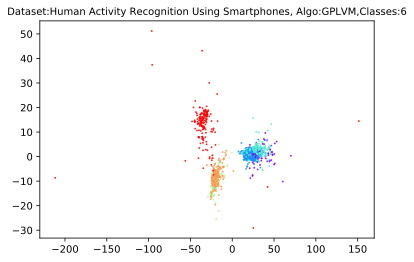

In [6]:
%config InlineBackend.figure_format = 'svg'
import numpy as np
from numpy import genfromtxt
from sklearn.decomposition import PCA , KernelPCA
from sklearn.manifold import MDS,TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import h5py
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from autograd import grad
from tqdm import tqdm_notebook as tqdm
import math
import autograd.numpy as np
from sklearn.datasets import fetch_olivetti_faces

#Wine Data Set#  https://archive.ics.uci.edu/ml/Datasetss/wine
def getWineData():
    y= genfromtxt('Datasets/wineX.txt', delimiter=',')
    labels = genfromtxt('Datasets/wineY.txt', delimiter=',',dtype=np.int)
    labels=labels.astype(int)
    labels=labels-1
    return y,labels

# USPS Dataset# https://www.kaggle.com/bistaumanga/usps-dataset
def getUSPSData():
    filename='Datasets/usps.h5'
    with h5py.File(filename, 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_te = test.get('target')[:]
    y=X_tr
    labels=y_tr
    return y,labels

#Olivetti faces Datasets#    https://scikit-learn.org/0.19/Datasetss/olivetti_faces.html
def getOlivettiData():
    # y = genfromtxt('Datasets/olivettifacesX.txt', delimiter=',')
    # y= y/255
    # labels = genfromtxt('Datasets/olivettifacesY.txt', delimiter='\n',dtype=np.int)
    y=np.loadtxt("Datasets/olivetti_X.csv", delimiter = ",")
    labels=np.loadtxt("Datasets/olivetti_y.csv", delimiter = ",")
    labels=labels.astype(int)
    return y,labels

#Oil Flow Datasets#
def getOilFlowData():
    y=pd.read_csv('Datasets/OilflowX.txt', header=None, sep='\s+').values
    labels=(pd.read_csv('Datasets/OilflowY.txt', header=None, sep='\s+').values)
    labelstemp=[]
    for i in labels:
        labelstemp.append(np.where(i==1)[0][0])
    labels=np.asarray(labelstemp)
    return y,labels

#Vowel Datasets#    https://www.openml.org/d/58 
def getVowelDataset():
    y = genfromtxt('Datasets/vowelX.txt', delimiter=',')
    labels = genfromtxt('Datasets/vowelY.txt', delimiter=',',dtype=np.int)
    return y,labels

def getBreastCancerDataset():
    from sklearn.datasets import load_breast_cancer
    data = load_breast_cancer()
    y=data['data']
    labels=data['target']
    return y,labels

#http://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones
def getHARdataset():
    y=np.loadtxt('Datasets\X_test.txt')
    labels=np.loadtxt('Datasets\y_test.txt').astype(int)-1
    return y,labels

def plot2D(X,y,title):
    labels = np.unique(y)
    Ncolors = len(labels)
    xx = np.arange(Ncolors)
    ys = [i+xx+(i*xx)**2 for i in range(Ncolors)]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))
    c = 1.0
    for label in labels:
        classIdx = np.where(y==label)[0]
        Xclass = X[classIdx,:]
        plt.scatter(Xclass[:,0],Xclass[:,1],linewidths=1,s=1,color=colors[label],marker='o',alpha=0.75)
        c += 1.
    title+=',Classes:'+str(len(labels))
    plt.title(title, fontsize=10)
    filename="".join(t for t in title if t.isalnum())
    plt.savefig('Plots/'+filename+'.svg',format='svg', dpi=1200)
    plt.show()

# RBF kernel    
def rbf(X, sigma_f, length_scale, noise_coef=0.):
    num_points = X.shape[0]
    cov = np.dot(X, X.T)
    diag = np.diag(cov)
    # (x_n - x_m)' (x_n - x_m) = x_n'x_n + x_m'x_m - 2x_n'x_m
    cov_ = diag.reshape((num_points, 1)) + diag.reshape((1, num_points)) - 2 * cov
    return (sigma_f ** 2.) * np.exp(-1. / (2 * length_scale ** 2.) * cov_) + noise_coef * np.eye(num_points)

# Characteristic function for GP-LVM
def loglik(K, Y):
    
    D, N = Y.shape
    K_inv = np.linalg.inv(K)

    return -D*N/2*np.log(2*np.pi) - D/2*np.linalg.slogdet(K)[1] - 0.5*np.trace(np.dot(np.dot(K_inv, Y), Y.T))
 

def sievingGPLVMalgo(lowerDim, Y, alpha, beta, gamma):
    X, alpha, beta, gamma = GPLVMfit(Y, lowerDim, alpha, beta, gamma, num_iter=10, learn_rate=1e-5, verbose=False, log_every=1)
    return X


def GPLVMalgo(y, labels, title):
    alpha, beta, gamma = 1., 1e-4, 1.
    X, alpha, beta, gamma=GPLVMfit(y, 2, alpha, beta, gamma, num_iter=100, learn_rate=1e-5, verbose=True, log_every=1)
    # np.savetxt('GPLVMData/gplvm_lowX.txt',X)
    # save=[alpha,beta,gamma]
    # np.savetxt('GPLVMData/gplvm_Param.txt',save)
    title=title+', Algo:GPLVM'
    KNNScore(X,labels,title)
    plot2D(X,labels,title)


def GPLVMfit(Y, latent_dim, alpha, beta, gamma, learn_rate=1e-6, num_iter=100, verbose=True, log_every=50):    
    # Initial guess for X
    # pca = PCA(n_components=latent_dim)
    # X = pca.fit_transform(Y)
    from sklearn.manifold import Isomap
    embedding = Isomap(n_components=2)
    X = embedding.fit_transform(Y)
    K = rbf(X, alpha, gamma, beta)
    L = loglik(K, Y)
    loglik_lambda = lambda X_, alpha_, beta_, gamma_: loglik(rbf(X_, alpha_, gamma_, beta_), Y)
    theta = [X, alpha, beta, gamma]
    dloglik_dtheta = [grad(loglik_lambda, i) for i in range(len(theta))]
    for i in tqdm(range(num_iter)):
        
        grads = [loglik_partial(*theta) for loglik_partial in dloglik_dtheta]
        print('1')
        theta[0] = theta[0] + learn_rate * grads[0] #[theta[j] + learn_rate * gradient for j, gradient in enumerate(grads)]
        print('2')
        theta[1] = theta[1] + learn_rate * grads[1]
        print('3')
        theta[2] = theta[2] + 1e-15 * grads[2]
        print('4')
        theta[3] = theta[3] + 1e-7 * grads[3]
        # save=tuple(theta[1],theta[2],theta[3])
        save=[theta,loglik_lambda(*theta)]
        save=np.asarray(save)  

        np.save('GPLVMData/gplvm_iter'+str(i)+'.npy',save)
        print("Log-likelihood (iteration {}): {:.3f}".format(i + 1, loglik_lambda(*theta)))
    
    if verbose:
        print("Final log-likelihood: {:.3f}".format(loglik_lambda(*theta)))
    return tuple(theta)

def ISOMapandPlot(y,labels,title,plot):
        latent_dim=2
        from sklearn.manifold import Isomap
        embedding = Isomap(n_components=2)
        X_transformed = embedding.fit_transform(y)
        title=title+', Algo:ISOMAP'
        KNNScore(X_transformed,labels,title)
        if(plot):
             plot2D(X_transformed,labels,title)


def PCAandPlot(y,labels,title,plot):
        latent_dim=2
        pca = PCA(n_components=latent_dim)
        X_pca = pca.fit_transform(y)
        X_pca = X_pca
        title=title+', Algo:PCA'
        KNNScore(X_pca,labels,title)
        if(plot):
             plot2D(X_pca,labels,title)

def KernelPCAandPlot(y,labels,title,plot):
        latent_dim=2
        kpca = KernelPCA(n_components=latent_dim,kernel='poly')
        X_kpca = kpca.fit_transform(y)
        X_kpca = X_kpca
        title=title+', Algo:Kernel PCA'
        KNNScore(X_kpca,labels,title)
        if(plot):
            plot2D(X_kpca,labels,title)

def MDSandPlot(y,labels,title,plot):
        latent_dim=2
        embedding = MDS(n_components=2,metric=False)
        X_transformed = embedding.fit_transform(y)
        title=title+', Algo:MDS'
        KNNScore(X_transformed,labels,title)
        if(plot):
            plot2D(X_transformed,labels,title)

def TSNEandPlot(y,labels,title,plot):
        X_embedded = TSNE(n_components=2).fit_transform(y)
        title+=', Algo:TSNE'
        KNNScore(X_embedded,labels,title)
        if(plot):
            plot2D(X_embedded,labels,title)      

def KNNScore(x,y,title):
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
        knn = KNeighborsClassifier(n_neighbors=1)
        # Fit a nearest neighbor classifier on the embedded training set
        knn.fit(X_train, y_train)
        # Compute the nearest neighbor accuracy on the embedded test set
        acc_knn = knn.score(X_test, y_test) #Return the mean accuracy on the given test data and labels.
        print(title+',Accuracy Score:'+str(acc_knn))

# dataset_name='Dataset:Oil Flow'
# y,labels=getOilFlowData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# PCAandPlot(y,labels,dataset_name,plot=True)
# GPLVMalgo(y,labels,dataset_name)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

# dataset_name='Dataset:Vowels'
# y,labels=getVowelDataset()
# labels=labels.astype(int)
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

dataset_name='Dataset:Human Activity Recognition Using Smartphones'
y,labels=getHARdataset()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
y_train,y_test, labeels_train, labels_test = train_test_split(y, labels, test_size=0.33, random_state=42)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)
GPLVMalgo(y_test,labels_test,dataset_name)


# dataset_name='Dataset:Olivetti faces'
# y,labels=getOlivettiData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# GPLVMalgo(y,labels,dataset_name)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

# dataset_name='Dataset:Wine (UCI)'
# y,labels=getWineData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)

# dataset_name='Dataset:USPS Digits'
# y,labels=getUSPSData()
# ISOMapandPlot(y,labels,dataset_name,plot=True)
# y_train,y_test, labeels_train, labels_test = train_test_split(y, labels, test_size=0.33, random_state=42)
# GPLVMalgo(y_test,labels_test,dataset_name)
# PCAandPlot(y,labels,dataset_name,plot=True)
# MDSandPlot(y,labels,dataset_name,plot=True)
# KernelPCAandPlot(y,labels,dataset_name,plot=True)
# TSNEandPlot(y,labels,dataset_name,plot=True)
